
# 🧠 Medulloblastoma Classification
This notebook guides you through analyzing pathomic, radiomic, and clinical features for medulloblastoma subjects. See documentation on this approach:

- General classification: https://scikit-learn.org/stable/auto_examples/classification/index.html

- SMOTE: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

First let's load the requisite Python packages:

In [ ]:
!pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.datasets import make_classification
from numpy import where
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

Load the cleaned features, if not already in your workspace environment

In [ ]:
from google.colab import files
uploaded = files.upload()

df_clinical = pd.read_csv('clinical_data_2025_07_10_oneline_initialOnly.csv')
df_molec_pathomic = pd.read_csv('molec_subtypes_2025_07_30_pathomics.csv')
df_pathomic = pd.read_csv('pathomic_feats.csv')
df_molec_radiomic = pd.read_csv('molec_subtypes_2025_07_30_radiomics.csv')
df_radiomic = pd.read_csv('radiomic_feats.csv')

Add the column `Age at Diagnosis` from the clinical data table to the imaging feature tables

In [3]:
print ("\033[1mPathomic\033[0m", df_pathomic.shape)
print ("\033[1mRadiomic\033[0m", df_radiomic.shape)

age_col = df_clinical['Age at Diagnosis Days']
df_pathomic = pd.concat([df_pathomic, age_col], axis=1) #df_pathomic now has age included
df_radiomic = pd.concat([df_radiomic, age_col], axis=1) #df_radiomic now has age included

print ("\n\033[1mPathomic New\033[0m", df_pathomic.shape)

print ("\033[1mRadiomic New\033[0m", df_radiomic.shape)

Pathomic (240, 131)
Radiomic (156, 556)

Pathomic New (276, 132)
Radiomic New (276, 557)


In [4]:
# Merging Radiomic and Pathomic
  #FILE NAME = df_rad_path

# Merge (inner join to keep only common subjects, but keep ALL rows)
df_combined = pd.merge(
    df_radiomic,
    df_pathomic,
    on='CBTN Subject ID',
    how='inner',
    suffixes=('_radiomic', '_pathomic'))

#Fix 'Age' column issue
df_combined['Age at Diagnosis Days'] = df_combined['Age at Diagnosis Days_radiomic']
df_combined.drop(columns=['Age at Diagnosis Days_radiomic', 'Age at Diagnosis Days_pathomic'], inplace=True)

# Define column sets
radiomic_features = df_radiomic.columns.difference(['CBTN Subject ID','Age at Diagnosis Days']).tolist()
pathomic_features = df_pathomic.columns.difference(['CBTN Subject ID', 'CBTN Specimen Group ID','Age at Diagnosis Days']).tolist()
final_columns = ['CBTN Subject ID', 'CBTN Specimen Group ID','Age at Diagnosis Days'] + radiomic_features + pathomic_features
df_rad_path = df_combined[final_columns]


# Merging Radiomic and Pathomic Molecular Subtypes
  #FILE NAME = df_molec_combined

# Merge (inner join to keep only common subjects, but keep ALL rows)
df_molec_combined = pd.merge(
    df_molec_radiomic,
    df_molec_pathomic,
    on='CBTN Subject ID',
    how='inner',
    suffixes=('_radiomic', '_pathomic'))

# Fix 'OpenPed' column issues
df_molec_combined['CBTN Specimen Group ID'] = df_molec_combined['CBTN Specimen Group ID_radiomic']
df_molec_combined['OpenPedCan Molecular Subtype'] = df_molec_combined['OpenPedCan Molecular Subtype_radiomic']

# Drop the duplicates
df_molec_combined.drop(columns=[
    'CBTN Specimen Group ID_radiomic',
    'CBTN Specimen Group ID_pathomic',
    'OpenPedCan Molecular Subtype_radiomic',
    'OpenPedCan Molecular Subtype_pathomic'], inplace=True)


#Keep common subjects only
subjects_features = set(df_rad_path['CBTN Subject ID'])
subjects_molecular = set(df_molec_combined['CBTN Subject ID'])
common_subjects = subjects_features & subjects_molecular

df_rad_path = df_rad_path[df_rad_path['CBTN Subject ID'].isin(common_subjects)].reset_index(drop=True)
df_molec_combined = df_molec_combined[df_molec_combined['CBTN Subject ID'].isin(common_subjects)].reset_index(drop=True)
df_molec_combined = df_molec_combined[df_molec_combined['CBTN Subject ID'].isin(common_subjects)].drop_duplicates(subset='CBTN Subject ID').reset_index(drop=True)

print("Final shape features:", df_rad_path.shape)
print("Final shape molecular subtypes:", df_molec_combined.shape)


#Save everything
file_path = '/content/df_rad_path.csv'
df_rad_path.to_csv(file_path, index=False)

#from google.colab import files
#files.download(file_path)

file_path = '/content/df_molec_combined.csv'
df_molec_combined.to_csv(file_path, index=False)

#from google.colab import files
#files.download(file_path)

Final shape features: (86, 687)
Final shape molecular subtypes: (86, 3)


## Classification of subtype

Initialize an SVM classifier.

In [5]:
# Merge subtype labels into radiomic data
df_rad = df_radiomic.merge(df_molec_radiomic[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape radiomic', df_rad.shape)

X_rad = df_rad.drop(columns=['CBTN Subject ID', 'OpenPedCan Molecular Subtype'])
y_rad = df_rad['OpenPedCan Molecular Subtype']

clf_rad = LinearSVC(random_state=42, max_iter=10000)

# Merge subtype labels into pathomic data
df_path = df_pathomic.merge(df_molec_pathomic[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape pathomic', df_path.shape)

X_path = df_path.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'OpenPedCan Molecular Subtype'])
y_path = df_path['OpenPedCan Molecular Subtype']

clf_path = LinearSVC(random_state=42, max_iter=10000)

# Merge subtype labels into radiomic+pathomic data
df_rp = df_rad_path.merge(df_molec_combined[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape combined', df_rp.shape)

X_rp = df_rp.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'OpenPedCan Molecular Subtype'])
y_rp = df_rp['OpenPedCan Molecular Subtype']

clf_rp = LinearSVC(random_state=42, max_iter=10000)

Shape radiomic (96, 558)
Shape pathomic (173, 133)
Shape combined (86, 688)


In [6]:
#RBF KERNEL clf

# Merge subtype labels into radiomic data
df_rad = df_radiomic.merge(df_molec_radiomic[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape radiomic', df_rad.shape)

X_rad = df_rad.drop(columns=['CBTN Subject ID', 'OpenPedCan Molecular Subtype'])
y_rad = df_rad['OpenPedCan Molecular Subtype']

clf_rad_kernel = svm.SVC(kernel='rbf')

# Merge subtype labels into pathomic data
df_path = df_pathomic.merge(df_molec_pathomic[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape pathomic', df_path.shape)

X_path = df_path.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'OpenPedCan Molecular Subtype'])
y_path = df_path['OpenPedCan Molecular Subtype']

clf_path_kernel = svm.SVC(kernel='rbf')

# Merge subtype labels into radiomic+pathomic data
df_rp = df_rad_path.merge(df_molec_combined[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape combined', df_rp.shape)

X_rp = df_rp.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'OpenPedCan Molecular Subtype'])
y_rp = df_rp['OpenPedCan Molecular Subtype']

clf_rp_kernel = svm.SVC(kernel='rbf')

Shape radiomic (96, 558)
Shape pathomic (173, 133)
Shape combined (86, 688)


In [7]:
#LINEAR KERNEL clf

# Merge subtype labels into radiomic data
df_rad = df_radiomic.merge(df_molec_radiomic[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape radiomic', df_rad.shape)

X_rad = df_rad.drop(columns=['CBTN Subject ID', 'OpenPedCan Molecular Subtype'])
y_rad = df_rad['OpenPedCan Molecular Subtype']

clf_rad_LK = svm.SVC(kernel='linear')

# Merge subtype labels into pathomic data
df_path = df_pathomic.merge(df_molec_pathomic[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape pathomic', df_path.shape)

X_path = df_path.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'OpenPedCan Molecular Subtype'])
y_path = df_path['OpenPedCan Molecular Subtype']

clf_path_LK = svm.SVC(kernel='linear')

# Merge subtype labels into radiomic+pathomic data
df_rp = df_rad_path.merge(df_molec_combined[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape combined', df_rp.shape)

X_rp = df_rp.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'OpenPedCan Molecular Subtype'])
y_rp = df_rp['OpenPedCan Molecular Subtype']

clf_rp_LK = svm.SVC(kernel='linear')

Shape radiomic (96, 558)
Shape pathomic (173, 133)
Shape combined (86, 688)


For each unique subject ID, split the subject's data as a separate test set from the rest of the training data. Fit the model to the training data, and use the fitted model to predict the class of the held-out sample. Construct an array/list of the results, including the `true-class-label` and `predicted-class-label` for each sample.

As input to `model.fit`/`model.predict`, `X` and `y` will need to be numpy array format (e.g., `X.values`).

For the radiomic features, on each loop iteration select the top 5% of features (`selector = SelectPercentile(f_classif, percentile=5)`) using only the training data, before running the classification training/testing

##4 Subtypes Analysis (SHH vs WNT vs Group 3 vs Group 4)

###Radiomic

In [ ]:
#RADIOMIC 5%
subjs_list_rad = df_rad['CBTN Subject ID'].unique()
results_rad = []

print("\033[1mRadiomic\033[0m")

for sub_ids in subjs_list_rad:
    test_mask_rad = df_rad['CBTN Subject ID'] == sub_ids
    train_mask_rad = ~test_mask_rad

    X_train_rad = X_rad[train_mask_rad].values
    y_train_rad = y_rad[train_mask_rad].values
    X_test_rad = X_rad[test_mask_rad].values
    y_test_rad = y_rad[test_mask_rad].values

    # Feature selection using training data only
    selector = SelectPercentile(score_func=f_classif, percentile=5)
    X_train_sel = selector.fit_transform(X_train_rad, y_train_rad)
    X_test_sel = selector.transform(X_test_rad)

    # Fit and predict
    clf_rad.fit(X_train_sel, y_train_rad)
    y_pred_rad = clf_rad.predict(X_test_sel)

    # Store results
    for true, pred in zip(y_test_rad, y_pred_rad):
        results_rad.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_rad = pd.DataFrame(results_rad)
print(results_df_rad)

Radiomic

Average Accuracy: 0.5729166666666666
Weighted F1 Score: 0.5666790974763111
AUC Score: 0.6984289489320449


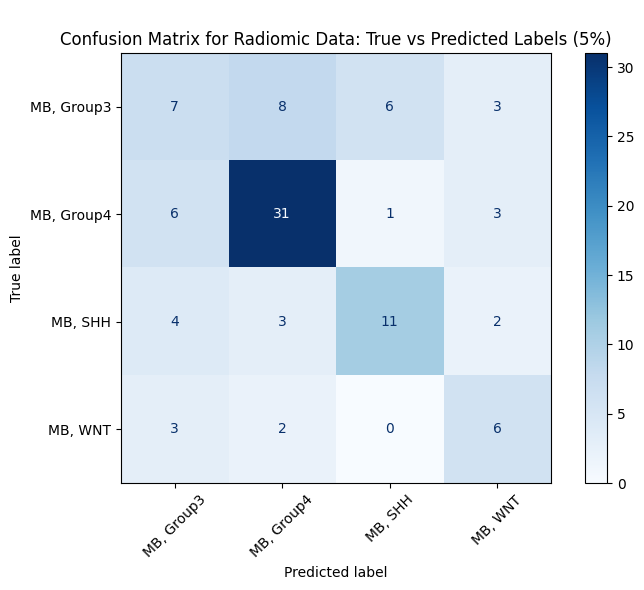

In [64]:
#RADIOMIC 5%

print("\033[1mRadiomic\033[0m")

#Accuracy score
avg_accuracy = accuracy_score(results_df_rad['True Label'], results_df_rad['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy)

#F1 score
avg_f1 = f1_score(results_df_rad['True Label'], results_df_rad['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_rad['True Label'])
y_pred_bin = lb.transform(results_df_rad['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score)

#Plot
cm = confusion_matrix(results_df_rad['True Label'], results_df_rad['Predicted Label'])

labels = sorted(results_df_rad['True Label'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Radiomic Data: True vs Predicted Labels (5%)")
plt.tight_layout()
plt.show()

In [ ]:
#RADIOMIC - rbf KERNEL
subjs_list_rad_k = df_rad['CBTN Subject ID'].unique()
results_rad_k = []

print("\033[1mRadiomic - kernel\033[0m")

for sub_ids in subjs_list_rad_k:
    test_mask_rad_k = df_rad['CBTN Subject ID'] == sub_ids
    train_mask_rad_k = ~test_mask_rad_k

    X_train_rad_k = X_rad[train_mask_rad_k].values
    y_train_rad_k = y_rad[train_mask_rad_k].values
    X_test_rad_k = X_rad[test_mask_rad_k].values
    y_test_rad_k = y_rad[test_mask_rad_k].values

    # Feature selection using training data only
    selector_k = SelectPercentile(score_func=f_classif, percentile=5)
    X_train_sel_k = selector_k.fit_transform(X_train_rad_k, y_train_rad_k)
    X_test_sel_k = selector_k.transform(X_test_rad_k)

    # Fit and predict
    clf_rad_kernel.fit(X_train_sel_k, y_train_rad_k)
    y_pred_rad_k = clf_rad_kernel.predict(X_test_sel_k)

    # Store results
    for true, pred in zip(y_test_rad_k, y_pred_rad_k):
        results_rad_k.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_rad_k = pd.DataFrame(results_rad_k)
print(results_df_rad_k)

Radiomic - rbf kernel

Average Accuracy: 0.53125
Weighted F1 Score: 0.5179843304843305
AUC Score: 0.6474724020389656


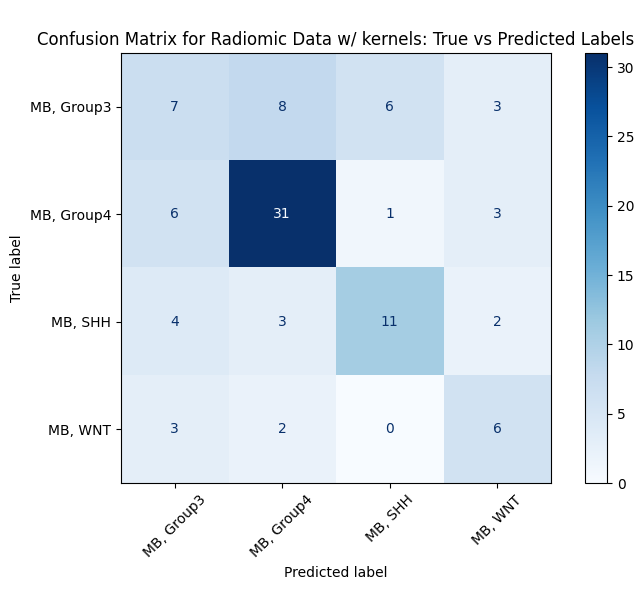

In [65]:
#RADIOMIC

print("\033[1mRadiomic - rbf kernel\033[0m")

#Accuracy score
avg_accuracy_k = accuracy_score(results_df_rad_k['True Label'], results_df_rad_k['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_k)

#F1 score
avg_f1_k = f1_score(results_df_rad_k['True Label'], results_df_rad_k['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_k)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_rad_k['True Label'])
y_pred_bin = lb.transform(results_df_rad_k['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_k = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_k = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_k)

#Plot
cm_k = confusion_matrix(results_df_rad_k['True Label'], results_df_rad_k['Predicted Label'])

labels = sorted(results_df_rad_k['True Label'].unique())
disp_k = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_k.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Radiomic Data w/ kernels: True vs Predicted Labels")
plt.tight_layout()
plt.show()

###Pathomic

In [ ]:
#PATHOMIC - all
subjs_list_path = df_path['CBTN Subject ID'].unique()
results_path = []

print("\033[1mPathomic\033[0m")

for sub_ids in subjs_list_path:
    test_mask_path = df_path['CBTN Subject ID'] == sub_ids
    train_mask_path = ~test_mask_path

    X_train_path = X_path[train_mask_path].values
    y_train_path = y_path[train_mask_path].values
    X_test_path = X_path[test_mask_path].values
    y_test_path = y_path[test_mask_path].values

    # Fit and predict
    clf_path.fit(X_train_path, y_train_path)
    y_pred_path = clf_path.predict(X_test_path)

    # Store results
    for true, pred in zip(y_test_path, y_pred_path):
        results_path.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_path = pd.DataFrame(results_path)
print(results_df_path)

Pathomic

Average Accuracy: 0.5433526011560693
Weighted F1 Score: 0.5384810434682383
AUC Score: 0.6694242223290996


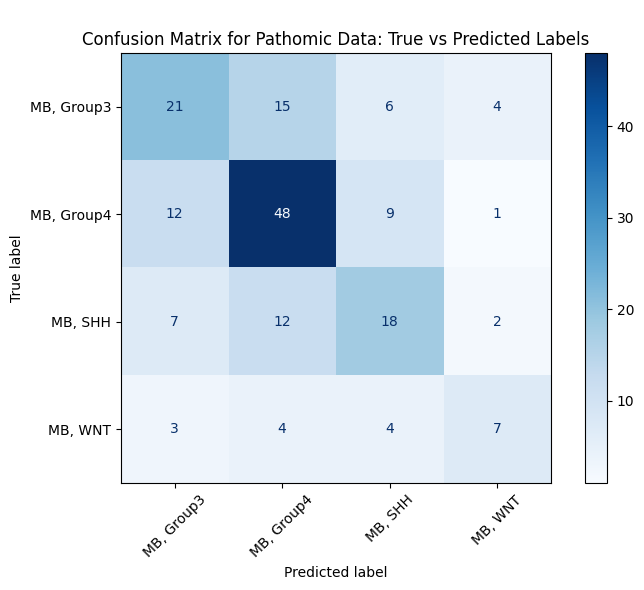

In [66]:
#PATHOMIC - all

print("\033[1mPathomic\033[0m")

#Accuracy score
avg_accuracy = accuracy_score(results_df_path['True Label'], results_df_path['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy)

#F1 score
avg_f1 = f1_score(results_df_path['True Label'], results_df_path['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_path['True Label'])
y_pred_bin = lb.transform(results_df_path['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score)

#Plot
cm = confusion_matrix(results_df_path['True Label'], results_df_path['Predicted Label'])

labels = sorted(results_df_path['True Label'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Pathomic Data: True vs Predicted Labels")
plt.tight_layout()
plt.show()

In [ ]:
#PATHOMIC - 5%
subjs_list_path_4 = df_path['CBTN Subject ID'].unique()
results_path_4 = []

print("\033[1mPathomic 5%\033[0m")

for sub_ids in subjs_list_path_4:
    test_mask_path_4 = df_path['CBTN Subject ID'] == sub_ids
    train_mask_path_4 = ~test_mask_path_4

    X_train_path_4 = X_path[train_mask_path_4].values
    y_train_path_4 = y_path[train_mask_path_4].values
    X_test_path_4 = X_path[test_mask_path_4].values
    y_test_path_4 = y_path[test_mask_path_4].values

    # Feature selection using training data only
    selector_4 = SelectPercentile(score_func=f_classif, percentile=5)
    X_train_sel_4 = selector_4.fit_transform(X_train_path_4, y_train_path_4)
    X_test_sel_4 = selector_4.transform(X_test_path_4)

    # Fit and predict
    clf_path.fit(X_train_sel_4, y_train_path_4)
    y_pred_path_4 = clf_path.predict(X_test_sel_4)

    # Store results
    for true, pred in zip(y_test_path_4, y_pred_path_4):
        results_path_4.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_path_4 = pd.DataFrame(results_path_4)
print(results_df_path_4)


Pathomic - 5%

Average Accuracy: 0.44508670520231214
Weighted F1 Score: 0.4079207428548054
AUC Score: 0.5817918442096847


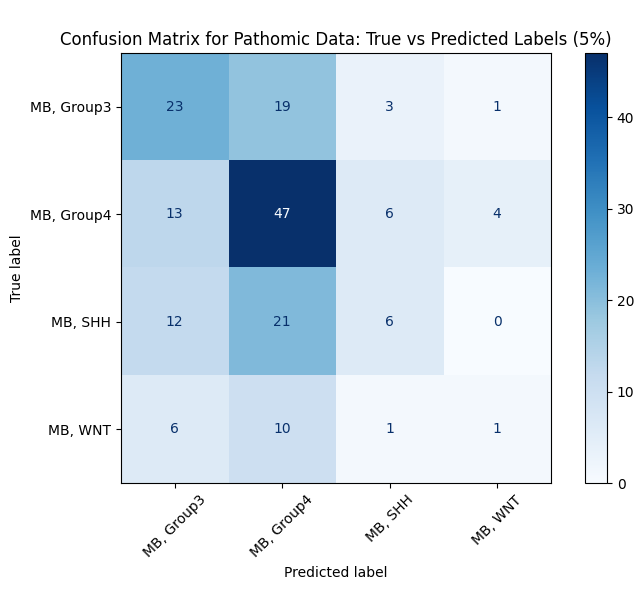

In [67]:
#PATHOMIC - 5%

print("\033[1mPathomic - 5%\033[0m")

#Accuracy score
avg_accuracy_4 = accuracy_score(results_df_path_4['True Label'], results_df_path_4['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_4)

#F1 score
avg_f1_4 = f1_score(results_df_path_4['True Label'], results_df_path_4['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_4)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_path_4['True Label'])
y_pred_bin = lb.transform(results_df_path_4['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_4 = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_4 = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_4)

#Plot
cm = confusion_matrix(results_df_path_4['True Label'], results_df_path_4['Predicted Label'])

labels = sorted(results_df_path_4['True Label'].unique())
disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_4.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Pathomic Data: True vs Predicted Labels (5%)")
plt.tight_layout()
plt.show()

In [ ]:
#PATHOMIC - rbf KERNEL
subjs_list_path_k = df_path['CBTN Subject ID'].unique()
results_path_k = []

print("\033[1mPathomic - kernel\033[0m")

for sub_ids in subjs_list_path_k:
    test_mask_path_k = df_path['CBTN Subject ID'] == sub_ids
    train_mask_path_k = ~test_mask_path_k

    X_train_path_k = X_path[train_mask_path_k].values
    y_train_path_k = y_path[train_mask_path_k].values
    X_test_path_k = X_path[test_mask_path_k].values
    y_test_path_k = y_path[test_mask_path_k].values

    # Feature selection using training data only
    selector_k = SelectPercentile(score_func=f_classif, percentile=5)
    X_train_sel_k = selector_k.fit_transform(X_train_path_k, y_train_path_k)
    X_test_sel_k = selector_k.transform(X_test_path_k)

    # Fit and predict
    clf_path_kernel.fit(X_train_sel_k, y_train_path_k)
    y_pred_path_k = clf_path_kernel.predict(X_test_sel_k)

    # Store results
    for true, pred in zip(y_test_path_k, y_pred_path_k):
        results_path_k.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_path_k = pd.DataFrame(results_path_k)
print(results_df_path_k)

Pathomic - rbf kernel

Average Accuracy: 0.4393063583815029
Weighted F1 Score: 0.39072528967122644
AUC Score: 0.5659473819599719


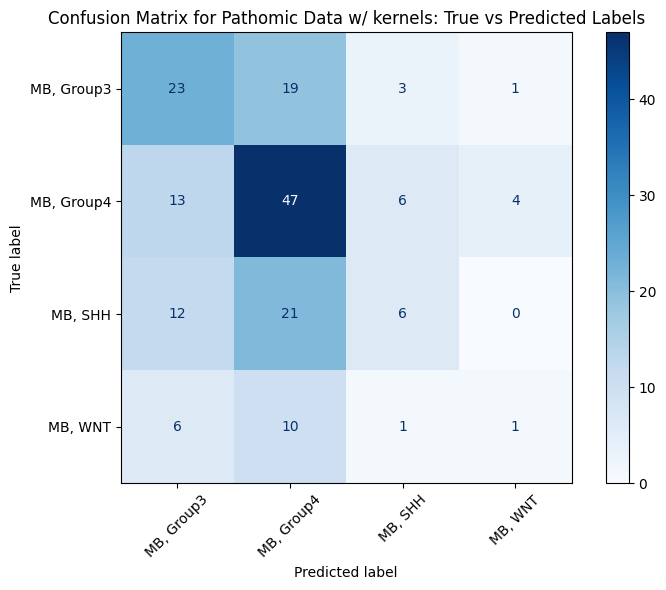

In [68]:
#PATHOMIC

print("\033[1mPathomic - rbf kernel\033[0m")

#Accuracy score
avg_accuracy_k = accuracy_score(results_df_path_k['True Label'], results_df_path_k['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_k)

#F1 score
avg_f1_k = f1_score(results_df_path_k['True Label'], results_df_path_k['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_k)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_path_k['True Label'])
y_pred_bin = lb.transform(results_df_path_k['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_k = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_k = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_k)

#Plot
cm_k = confusion_matrix(results_df_path_k['True Label'], results_df_path_k['Predicted Label'])

labels = sorted(results_df_path_k['True Label'].unique())
disp_k = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_k.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Pathomic Data w/ kernels: True vs Predicted Labels")
plt.tight_layout()
plt.show()

###Combined

In [ ]:
#COMBINED - all
subjs_list_rp = df_rp['CBTN Subject ID'].unique()
results_rp = []

print("\033[1mCombined\033[0m")

for sub_ids in subjs_list_rp:
    test_mask_rp = df_rp['CBTN Subject ID'] == sub_ids
    train_mask_rp = ~test_mask_rp

    X_train_rp = X_rp[train_mask_rp].values
    y_train_rp = y_rp[train_mask_rp].values
    X_test_rp = X_rp[test_mask_rp].values
    y_test_rp = y_rp[test_mask_rp].values

    scaler_rp = StandardScaler()
    X_train_rp = scaler_rp.fit_transform(X_train_rp)
    X_test_rp = scaler_rp.transform(X_test_rp)

    clf_rp.fit(X_train_rp, y_train_rp)
    y_pred_rp = clf_rp.predict(X_test_rp)

    # Store results
    for true, pred in zip(y_test_rp, y_pred_rp):
        results_rp.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_rp = pd.DataFrame(results_rp)
print(results_df_rp)

Combined

Average Accuracy: 0.5116279069767442
Weighted F1 Score: 0.5150853587691846
AUC Score: 0.6601486190975588


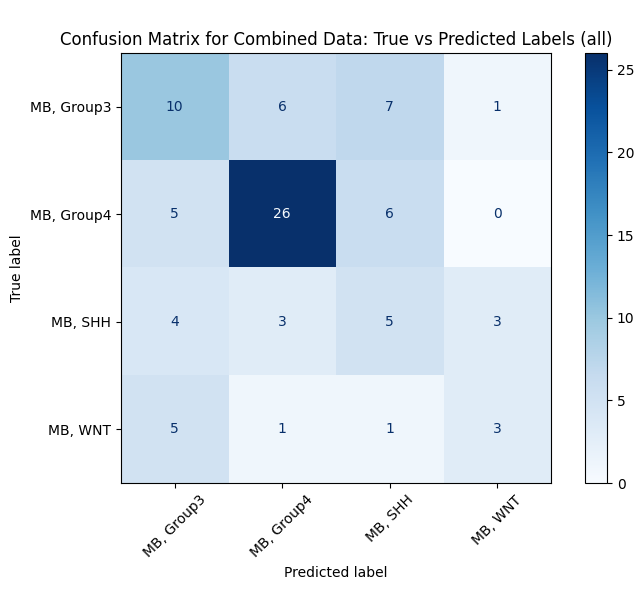

In [69]:
#COMBINED - all

print("\033[1mCombined\033[0m")

#Accuracy score
avg_accuracy = accuracy_score(results_df_rp['True Label'], results_df_rp['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy)

#F1 score
avg_f1 = f1_score(results_df_rp['True Label'], results_df_rp['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_rp['True Label'])
y_pred_bin = lb.transform(results_df_rp['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score)

#Plot
cm = confusion_matrix(results_df_rp['True Label'], results_df_rp['Predicted Label'])

labels = sorted(results_df_rp['True Label'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Combined Data: True vs Predicted Labels (all)")
plt.tight_layout()
plt.show()

In [ ]:
#COMBINED - 5%
subjs_list_rp_4 = df_rp['CBTN Subject ID'].unique()
results_rp_4 = []

print("\033[1mCombined 5%\033[0m")

for sub_ids in subjs_list_rp_4:
    test_mask_rp_4 = df_rp['CBTN Subject ID'] == sub_ids
    train_mask_rp_4 = ~test_mask_rp_4

    X_train_rp_4 = X_rp[train_mask_rp_4].values
    y_train_rp_4 = y_rp[train_mask_rp_4].values
    X_test_rp_4 = X_rp[test_mask_rp_4].values
    y_test_rp_4 = y_rp[test_mask_rp_4].values

    # Feature selection using training data only
    selector_4 = SelectPercentile(score_func=f_classif, percentile=5)
    X_train_sel_4 = selector_4.fit_transform(X_train_rp_4, y_train_rp_4)
    X_test_sel_4 = selector_4.transform(X_test_rp_4)

    # Fit and predict
    clf_rp.fit(X_train_sel_4, y_train_rp_4)
    y_pred_rp_4 = clf_rp.predict(X_test_sel_4)

    # Store results
    for true, pred in zip(y_test_rp_4, y_pred_rp_4):
        results_rp_4.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_rp_4 = pd.DataFrame(results_rp_4)
print(results_df_rp_4)


Combined - 5%

Average Accuracy: 0.5581395348837209
Weighted F1 Score: 0.5636600541615414
AUC Score: 0.6931419953141112


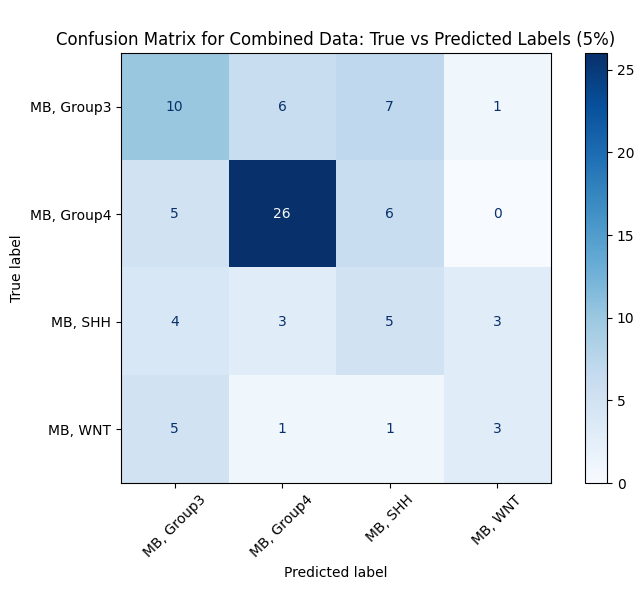

In [70]:
#COMBINED - 5%

print("\033[1mCombined - 5%\033[0m")

#Accuracy score
avg_accuracy_4 = accuracy_score(results_df_rp_4['True Label'], results_df_rp_4['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_4)

#F1 score
avg_f1_4 = f1_score(results_df_rp_4['True Label'], results_df_rp_4['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_4)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_rp_4['True Label'])
y_pred_bin = lb.transform(results_df_rp_4['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_4 = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_4 = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_4)

#Plot
cm_4 = confusion_matrix(results_df_rp_4['True Label'], results_df_rp_4['Predicted Label'])

labels = sorted(results_df_rp_4['True Label'].unique())
disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_4.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Combined Data: True vs Predicted Labels (5%)")
plt.tight_layout()
plt.show()

##3 Subtype Analysis (SHH vs WNT vs Group 3/4)

###Radiomic

In [22]:
#RADIOMIC

subtype_grouping = {
    'MB, SHH': 'SHH',
    'MB, WNT': 'WNT',
    'MB, Group3': 'Group 3/4',
    'MB, Group4': 'Group 3/4'}

#Merge labels with radiomic features
df_rad_3 = df_radiomic.merge(df_molec_radiomic[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape radiomic', df_rad_3.shape)

X_rad_3 = df_rad_3.drop(columns=['CBTN Subject ID', 'OpenPedCan Molecular Subtype'])
y_rad_3 = df_rad_3['OpenPedCan Molecular Subtype'].map(subtype_grouping)

clf_rad_3 = LinearSVC(random_state=42, max_iter=10000)

print('\n', y_rad_3.value_counts())

Shape radiomic (96, 558)

 OpenPedCan Molecular Subtype
Group 3/4    65
SHH          20
WNT          11
Name: count, dtype: int64


In [ ]:
#RADIOMIC - 5%
subjs_list_rad_3 = df_rad_3['CBTN Subject ID'].unique()
results_rad_3 = []

print("\033[1mRadiomic - 3 subtypes\033[0m")

for sub_ids in subjs_list_rad_3:
    test_mask_rad_3 = df_rad_3['CBTN Subject ID'] == sub_ids
    train_mask_rad_3 = ~test_mask_rad_3

    X_train_rad_3 = X_rad_3[train_mask_rad_3].values
    y_train_rad_3 = y_rad_3[train_mask_rad_3].values
    X_test_rad_3 = X_rad_3[test_mask_rad_3].values
    y_test_rad_3 = y_rad_3[test_mask_rad_3].values

    # Feature selection using training data only
    selector_3 = SelectPercentile(score_func=f_classif, percentile=5)
    X_train_sel_3 = selector_3.fit_transform(X_train_rad_3, y_train_rad_3)
    X_test_sel_3 = selector_3.transform(X_test_rad_3)

    # Fit and predict
    clf_rad_3.fit(X_train_sel_3, y_train_rad_3)
    y_pred_rad_3 = clf_rad_3.predict(X_test_sel_3)

    # Store results
    for true, pred in zip(y_test_rad_3, y_pred_rad_3):
        results_rad_3.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_rad_3 = pd.DataFrame(results_rad_3)
print(results_df_rad_3)

Radiomic - 3 subtype (5%)

Average Accuracy: 0.7291666666666666
Weighted F1 Score: 0.7267814867424242
AUC Score: 0.7478727654049736


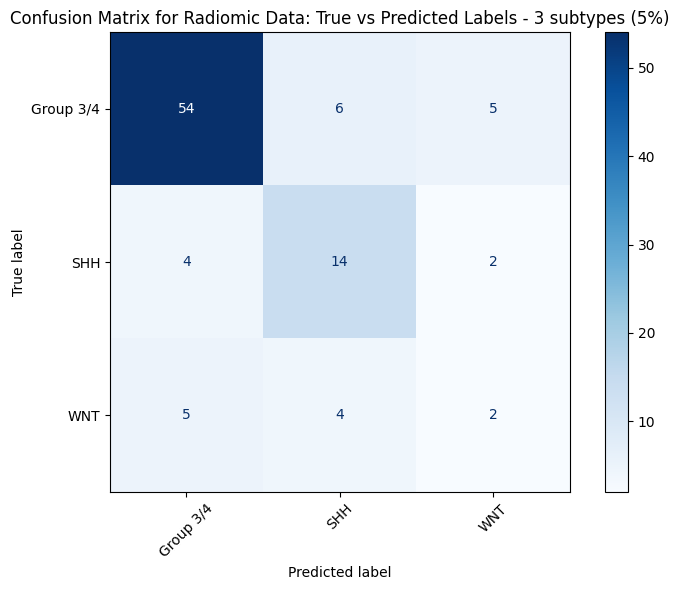

In [72]:
#RADIOMIC - 5%

print("\033[1mRadiomic - 3 subtype (5%)\033[0m")

#Accuracy score
avg_accuracy_3 = accuracy_score(results_df_rad_3['True Label'], results_df_rad_3['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_3)

#F1 score
avg_f1_3 = f1_score(results_df_rad_3['True Label'], results_df_rad_3['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_3)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_rad_3['True Label'])
y_pred_bin = lb.transform(results_df_rad_3['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_3 = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_3 = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_3)

#Plot
cm_3 = confusion_matrix(results_df_rad_3['True Label'], results_df_rad_3['Predicted Label'])

labels = sorted(results_df_rad_3['True Label'].unique())
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_3.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Radiomic Data: True vs Predicted Labels - 3 subtypes (5%)")
plt.tight_layout()
plt.show()

In [ ]:
#RADIOMIC - 10%
subjs_list_rad_3 = df_rad_3['CBTN Subject ID'].unique()
results_rad_10 = []

print("\033[1mRadiomic - 3 subtypes (10%)\033[0m")

for sub_ids in subjs_list_rad_3:
    test_mask_rad_10 = df_rad_3['CBTN Subject ID'] == sub_ids
    train_mask_rad_10 = ~test_mask_rad_10

    X_train_rad_10 = X_rad_3[train_mask_rad_10].values
    y_train_rad_10 = y_rad_3[train_mask_rad_10].values
    X_test_rad_10 = X_rad_3[test_mask_rad_10].values
    y_test_rad_10 = y_rad_3[test_mask_rad_10].values

    # Feature selection using training data only
    selector_10 = SelectPercentile(score_func=f_classif, percentile=10)
    X_train_sel_10 = selector_10.fit_transform(X_train_rad_10, y_train_rad_10)
    X_test_sel_10 = selector_10.transform(X_test_rad_10)

    # Fit and predict
    clf_rad_3.fit(X_train_sel_10, y_train_rad_10)
    y_pred_rad_10 = clf_rad_3.predict(X_test_sel_10)

    # Store results
    for true, pred in zip(y_test_rad_10, y_pred_rad_10):
        results_rad_10.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_rad_10 = pd.DataFrame(results_rad_10)
print(results_df_rad_10)

Radiomic - 3 subtypes (10%)

Average Accuracy: 0.65625
Weighted F1 Score: 0.6607147174007638
AUC Score: 0.6664061719764306


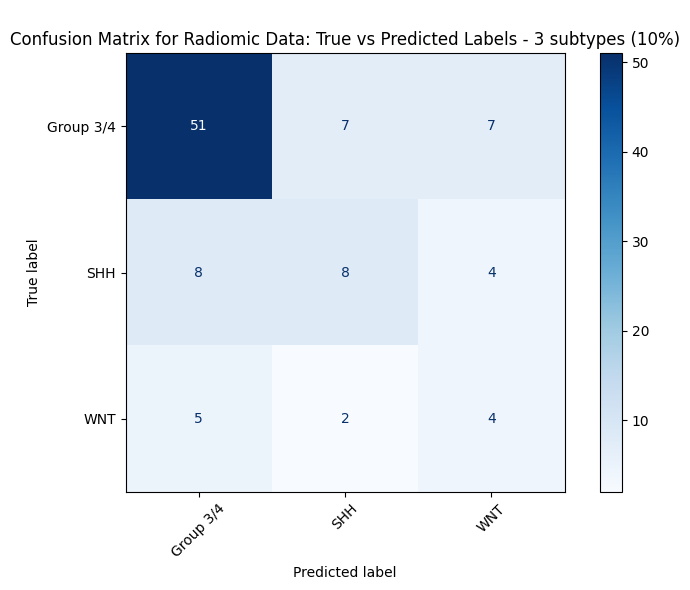

In [73]:
#RADIOMIC - 10%

print("\033[1mRadiomic - 3 subtypes (10%)\033[0m")

#Accuracy score
avg_accuracy_10 = accuracy_score(results_df_rad_10['True Label'], results_df_rad_10['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_10)

#F1 score
avg_f1_10 = f1_score(results_df_rad_10['True Label'], results_df_rad_10['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_10)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_rad_10['True Label'])
y_pred_bin = lb.transform(results_df_rad_10['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_10 = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_10 = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_10)

#Plot
cm_10 = confusion_matrix(results_df_rad_10['True Label'], results_df_rad_10['Predicted Label'])

labels = sorted(results_df_rad_10['True Label'].unique())
disp_10 = ConfusionMatrixDisplay(confusion_matrix=cm_10, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_10.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Radiomic Data: True vs Predicted Labels - 3 subtypes (10%)")
plt.tight_layout()
plt.show()

In [27]:
#RADIOMIC - 5% - Linear Kernel

X_rad_LK = df_rad_3.drop(columns=['CBTN Subject ID', 'OpenPedCan Molecular Subtype'])
y_rad_LK = df_rad_3['OpenPedCan Molecular Subtype'].map(subtype_grouping)

clf_rad_LK = svm.SVC(kernel='linear')

print(y_rad_LK.value_counts())

OpenPedCan Molecular Subtype
Group 3/4    65
SHH          20
WNT          11
Name: count, dtype: int64


In [ ]:
#RADIOMIC - 5% - LINEAR KERNER
subjs_list_rad_LK = df_rad_3['CBTN Subject ID'].unique()
results_rad_LK = []

print("\033[1mRadiomic - 3 subtypes (Linear Kernel)\033[0m")

for sub_ids in subjs_list_rad_LK:
    test_mask_rad_LK = df_rad_3['CBTN Subject ID'] == sub_ids
    train_mask_rad_LK = ~test_mask_rad_LK

    X_train_rad_LK = X_rad_3[train_mask_rad_LK].values
    y_train_rad_LK = y_rad_3[train_mask_rad_LK].values
    X_test_rad_LK = X_rad_3[test_mask_rad_LK].values
    y_test_rad_LK = y_rad_3[test_mask_rad_LK].values

    # Feature selection using training data only
    selector_LK = SelectPercentile(score_func=f_classif, percentile=5)
    X_train_sel_LK = selector_LK.fit_transform(X_train_rad_LK, y_train_rad_LK)
    X_test_sel_LK = selector_LK.transform(X_test_rad_LK)

    # Fit and predict
    clf_rad_LK.fit(X_train_sel_LK, y_train_rad_LK)
    y_pred_rad_LK = clf_rad_LK.predict(X_test_sel_LK)

    # Store results
    for true, pred in zip(y_test_rad_LK, y_pred_rad_LK):
        results_rad_LK.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_rad_LK = pd.DataFrame(results_rad_LK)
print(results_df_rad_LK)

Radiomic - 3 subtype (5%) - LINEAR KERNEL 

Average Accuracy: 0.6875
Weighted F1 Score: 0.6832579760211339
AUC Score: 0.6751997403375612


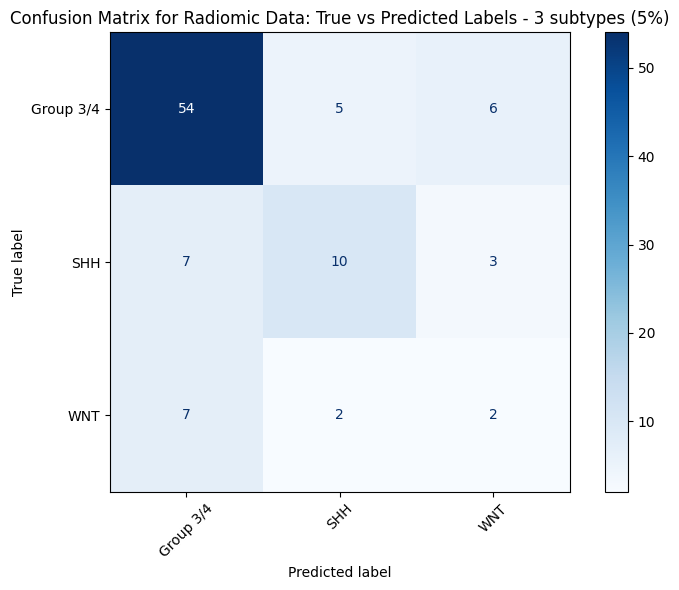

In [74]:
#RADIOMIC - 5% (LINEAR KERNEL)

print("\033[1mRadiomic - 3 subtype (5%) - LINEAR KERNEL \033[0m")

#Accuracy score
avg_accuracy_LK = accuracy_score(results_df_rad_LK['True Label'], results_df_rad_LK['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_LK)

#F1 score
avg_f1_LK = f1_score(results_df_rad_LK['True Label'], results_df_rad_LK['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_LK)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_rad_LK['True Label'])
y_pred_bin = lb.transform(results_df_rad_LK['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_LK = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_LK = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_LK)

#Plot
cm_LK = confusion_matrix(results_df_rad_LK['True Label'], results_df_rad_LK['Predicted Label'])

labels = sorted(results_df_rad_LK['True Label'].unique())
disp_LK = ConfusionMatrixDisplay(confusion_matrix=cm_LK, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_LK.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Radiomic Data: True vs Predicted Labels - 3 subtypes (5%)")
plt.tight_layout()
plt.show()

###Pathomic

In [30]:
#PATHOMIC

subtype_grouping = {
    'MB, SHH': 'SHH',
    'MB, WNT': 'WNT',
    'MB, Group3': 'Group 3/4',
    'MB, Group4': 'Group 3/4'}

#Merge labels with pathomic features
df_path_3 = df_pathomic.merge(df_molec_pathomic[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape pathomic', df_path_3.shape)

X_path_3 = df_path_3.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'OpenPedCan Molecular Subtype'])
y_path_3 = df_path_3['OpenPedCan Molecular Subtype'].map(subtype_grouping)

clf_path_3 = LinearSVC(random_state=42, max_iter=10000)

print('\n', y_path_3.value_counts())

Shape pathomic (173, 133)

 OpenPedCan Molecular Subtype
Group 3/4    116
SHH           39
WNT           18
Name: count, dtype: int64


In [ ]:
#PATHOMIC - all
subjs_list_path_3 = df_path_3['CBTN Subject ID'].unique()
results_path_3 = []

print("\033[1mPathomic - 3 subtypes\033[0m")

for sub_ids in subjs_list_path_3:
    test_mask_path_3 = df_path_3['CBTN Subject ID'] == sub_ids
    train_mask_path_3 = ~test_mask_path_3

    X_train_path_3 = X_path_3[train_mask_path_3].values
    y_train_path_3 = y_path_3[train_mask_path_3].values
    X_test_path_3 = X_path_3[test_mask_path_3].values
    y_test_path_3 = y_path_3[test_mask_path_3].values

    # Fit and predict
    clf_path_3.fit(X_train_path_3, y_train_path_3)
    y_pred_path_3 = clf_path_3.predict(X_test_path_3)

    # Store results
    for true, pred in zip(y_test_path_3, y_pred_path_3):
        results_path_3.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_path_3 = pd.DataFrame(results_path_3)
print(results_df_path_3)

Pathomic - 3 subtype

Average Accuracy: 0.6358381502890174
Weighted F1 Score: 0.5481294526761954
AUC Score: 0.4997964337903014


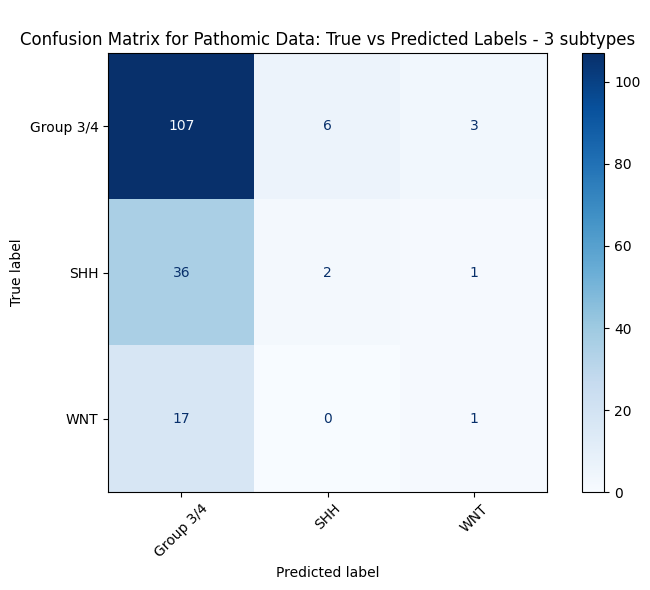

In [75]:
#PATHOMIC - all

print("\033[1mPathomic - 3 subtype\033[0m")

#Accuracy score
avg_accuracy_3 = accuracy_score(results_df_path_3['True Label'], results_df_path_3['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_3)

#F1 score
avg_f1_3 = f1_score(results_df_path_3['True Label'], results_df_path_3['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_3)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_path_3['True Label'])
y_pred_bin = lb.transform(results_df_path_3['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_3 = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_3 = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_3)

#Plot
cm_3 = confusion_matrix(results_df_path_3['True Label'], results_df_path_3['Predicted Label'])

labels = sorted(results_df_path_3['True Label'].unique())
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_3.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Pathomic Data: True vs Predicted Labels - 3 subtypes")
plt.tight_layout()
plt.show()

In [33]:
#PATHOMIC - 5%

subtype_grouping = {
    'MB, SHH': 'SHH',
    'MB, WNT': 'WNT',
    'MB, Group3': 'Group 3/4',
    'MB, Group4': 'Group 3/4'}

#Merge labels
df_path_3 = df_pathomic.merge(df_molec_pathomic[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape pathomic', df_path_3.shape)

X_path_3 = df_path_3.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'OpenPedCan Molecular Subtype'])
y_path_3 = df_path_3['OpenPedCan Molecular Subtype'].map(subtype_grouping)

clf_path_3 = LinearSVC(random_state=42, max_iter=10000)

print('\n', y_path_3.value_counts())

Shape pathomic (173, 133)

 OpenPedCan Molecular Subtype
Group 3/4    116
SHH           39
WNT           18
Name: count, dtype: int64


In [ ]:
#PATHOMIC - 5%
subjs_list_path_3 = df_path_3['CBTN Subject ID'].unique()
results_path_3 = []

print("\033[1mPathomic - 3 subtypes\033[0m")

for sub_ids in subjs_list_path_3:
    test_mask_path_3 = df_path_3['CBTN Subject ID'] == sub_ids
    train_mask_path_3 = ~test_mask_path_3

    X_train_path_3 = X_path_3[train_mask_path_3].values
    y_train_path_3 = y_path_3[train_mask_path_3].values
    X_test_path_3 = X_path_3[test_mask_path_3].values
    y_test_path_3 = y_path_3[test_mask_path_3].values

    # Feature selection using training data only
    selector_path_3 = SelectPercentile(score_func=f_classif, percentile=5)
    X_train_sel_path_3 = selector_path_3.fit_transform(X_train_path_3, y_train_path_3)
    X_test_sel_path_3 = selector_path_3.transform(X_test_path_3)

    # Fit and predict
    clf_path_3.fit(X_train_sel_path_3, y_train_path_3)
    y_pred_path_3 = clf_path_3.predict(X_test_sel_path_3)

    # Store results
    for true, pred in zip(y_test_path_3, y_pred_path_3):
        results_path_3.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_path_3 = pd.DataFrame(results_path_3)
print(results_df_path_3)

Pathomic - 3 subtype (5%)

Average Accuracy: 0.6358381502890174
Weighted F1 Score: 0.5481294526761954
AUC Score: 0.4997964337903014


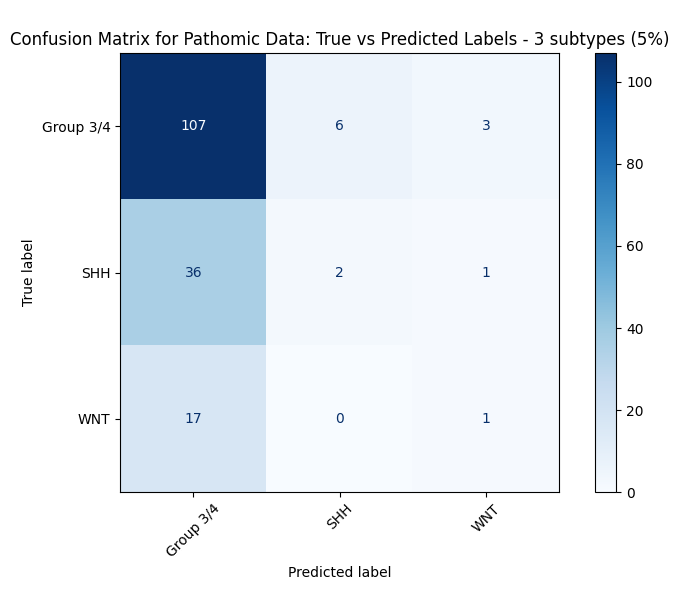

In [63]:
#PATHOMIC - 5%

print("\033[1mPathomic - 3 subtype (5%)\033[0m")

#Accuracy score
avg_accuracy_path_3 = accuracy_score(results_df_path_3['True Label'], results_df_path_3['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_path_3)

#F1 score
avg_f1_path_3 = f1_score(results_df_path_3['True Label'], results_df_path_3['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_path_3)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_path_3['True Label'])
y_pred_bin = lb.transform(results_df_path_3['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_path_3 = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_path_3 = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_path_3)

#Plot
cm_path_3 = confusion_matrix(results_df_path_3['True Label'], results_df_path_3['Predicted Label'])

labels = sorted(results_df_path_3['True Label'].unique())  # or use a manual list if the order matters
disp_path_3 = ConfusionMatrixDisplay(confusion_matrix=cm_path_3, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_path_3.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Pathomic Data: True vs Predicted Labels - 3 subtypes (5%)")
plt.tight_layout()
plt.show()

In [ ]:
#PATHOMIC - 10%
subjs_list_path_10 = df_path_3['CBTN Subject ID'].unique()
results_path_10 = []

print("\033[1mPathomic - 3 subtypes\033[0m")

for sub_ids in subjs_list_path_10:
    test_mask_path_10 = df_path_3['CBTN Subject ID'] == sub_ids
    train_mask_path_10 = ~test_mask_path_10

    X_train_path_10 = X_path_3[train_mask_path_10].values
    y_train_path_10 = y_path_3[train_mask_path_10].values
    X_test_path_10 = X_path_3[test_mask_path_10].values
    y_test_path_10 = y_path_3[test_mask_path_10].values

# Feature selection using training data only
    selector_path_10 = SelectPercentile(score_func=f_classif, percentile=10)
    X_train_sel_path_10 = selector_path_10.fit_transform(X_train_path_10, y_train_path_10)
    X_test_sel_path_10 = selector_path_10.transform(X_test_path_10)

    # Fit and predict
    clf_path_3.fit(X_train_sel_path_10, y_train_path_10)
    y_pred_path_10 = clf_path_3.predict(X_test_sel_path_10)

    # Store results
    for true, pred in zip(y_test_path_10, y_pred_path_10):
        results_path_10.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_path_10 = pd.DataFrame(results_path_10)
print(results_df_path_10)

Pathomic - 3 subtypes (10%)

Average Accuracy: 0.6473988439306358
Weighted F1 Score: 0.5705544111819917
AUC Score: 0.5223808799804036


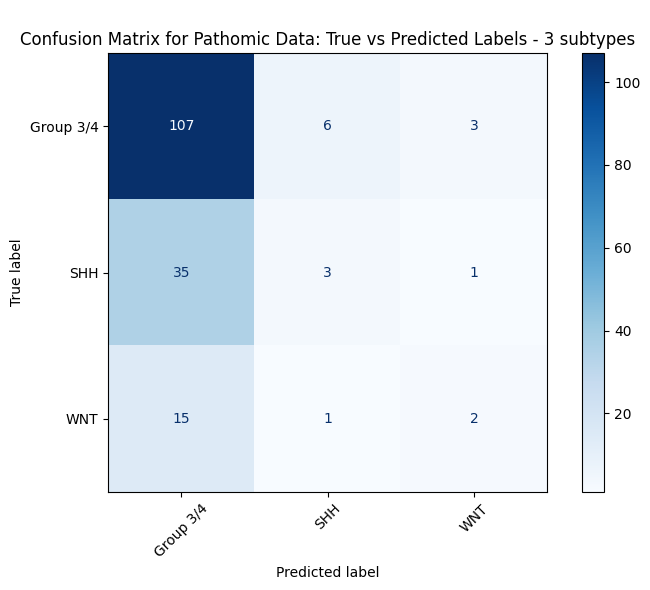

In [76]:
#PATHOMIC 10%

print("\033[1mPathomic - 3 subtypes (10%)\033[0m")

#Accuracy score
avg_accuracy_10 = accuracy_score(results_df_path_10['True Label'], results_df_path_10['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_10)

#F1 score
avg_f1_10 = f1_score(results_df_path_10['True Label'], results_df_path_10['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_10)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_path_10['True Label'])
y_pred_bin = lb.transform(results_df_path_10['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_10 = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_10 = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_10)

#Plot
cm_10 = confusion_matrix(results_df_path_10['True Label'], results_df_path_10['Predicted Label'])

labels = sorted(results_df_path_10['True Label'].unique())
disp_10 = ConfusionMatrixDisplay(confusion_matrix=cm_10, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_10.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Pathomic Data: True vs Predicted Labels - 3 subtypes")
plt.tight_layout()
plt.show()

In [38]:
#PATHOMIC - 5% - Linear Kernel

X_path_LK = df_path_3.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'OpenPedCan Molecular Subtype'])
y_path_LK = df_path_3['OpenPedCan Molecular Subtype'].map(subtype_grouping)

clf_path_LK = svm.SVC(kernel='linear')

print(y_path_LK.value_counts())

OpenPedCan Molecular Subtype
Group 3/4    116
SHH           39
WNT           18
Name: count, dtype: int64


In [ ]:
#PATHOMIC - 5% - Linear Kernel
subjs_list_path_LK = df_path_3['CBTN Subject ID'].unique()
results_path_LK = []

print("\033[1mPathomic - 3 subtypes (Linear Kernel)\033[0m")

for sub_ids in subjs_list_path_LK:
    test_mask_path_LK = df_path_3['CBTN Subject ID'] == sub_ids
    train_mask_path_LK = ~test_mask_path_LK

    X_train_path_LK = X_path_LK[train_mask_path_LK].values
    y_train_path_LK = y_path_LK[train_mask_path_LK].values
    X_test_path_LK = X_path_LK[test_mask_path_LK].values
    y_test_path_LK = y_path_LK[test_mask_path_LK].values

    # Feature selection using training data only
    selector_LK = SelectPercentile(score_func=f_classif, percentile=5)
    X_train_sel_LK = selector_LK.fit_transform(X_train_path_LK, y_train_path_LK)
    X_test_sel_LK = selector_LK.transform(X_test_path_LK)

    # Fit and predict
    clf_path_LK.fit(X_train_sel_LK, y_train_path_LK)
    y_pred_path_LK = clf_path_LK.predict(X_test_sel_LK)

    # Store results
    for true, pred in zip(y_test_path_LK, y_pred_path_LK):
        results_path_LK.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_path_LK = pd.DataFrame(results_path_LK)
print(results_df_path_LK)

Pathomic - 3 subtype (5%) - LINEAR KERNEL 

Average Accuracy: 0.6647398843930635
Weighted F1 Score: 0.5354849068721902
AUC Score: 0.4967741935483871


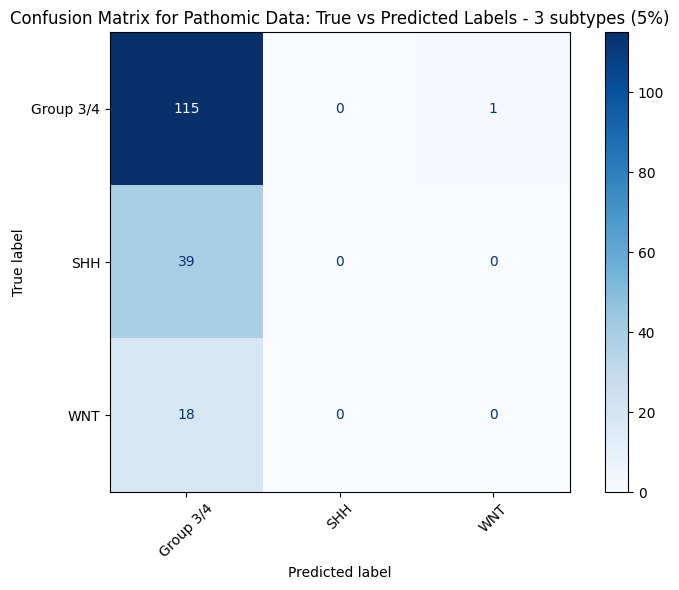

In [40]:
#PATHOMIC - 5% - LINEAR KERNEL

print("\033[1mPathomic - 3 subtype (5%) - LINEAR KERNEL \033[0m")

#Accuracy score
avg_accuracy_LK = accuracy_score(results_df_path_LK['True Label'], results_df_path_LK['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_LK)

#F1 score
avg_f1_LK = f1_score(results_df_path_LK['True Label'], results_df_path_LK['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_LK)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_path_LK['True Label'])
y_pred_bin = lb.transform(results_df_path_LK['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_LK = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_LK = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_LK)

#Plot
cm_LK = confusion_matrix(results_df_path_LK['True Label'], results_df_path_LK['Predicted Label'])

labels_sorted = sorted(results_df_path_LK['True Label'].unique())
disp_LK = ConfusionMatrixDisplay(confusion_matrix=cm_LK, display_labels=labels_sorted)

fig, ax = plt.subplots(figsize=(8, 6))
disp_LK.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Pathomic Data: True vs Predicted Labels - 3 subtypes (5%)")
plt.tight_layout()
plt.show()

###Combined (radiomic and pathomic)

In [41]:
#Combined
#File names: df_rad_path & df_molec_combined
  #File names pt 2: df_rp

subtype_grouping = {
    'MB, SHH': 'SHH',
    'MB, WNT': 'WNT',
    'MB, Group3': 'Group 3/4',
    'MB, Group4': 'Group 3/4'}

#Merge labels with radiomic features
df_rp_3 = df_rad_path.merge(df_molec_combined[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape radiomic', df_rp_3.shape)

X_rp_3 = df_rp_3.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'OpenPedCan Molecular Subtype'])
y_rp_3 = df_rp_3['OpenPedCan Molecular Subtype'].map(subtype_grouping)

clf_rp_3 = LinearSVC(random_state=42, max_iter=10000)

print('\n', y_rp_3.value_counts())

Shape radiomic (86, 688)

 OpenPedCan Molecular Subtype
Group 3/4    61
SHH          15
WNT          10
Name: count, dtype: int64


In [ ]:
#Combined - 5%
subjs_list_rp_3 = df_rp_3['CBTN Subject ID'].unique()
results_rp_3 = []

print("\033[1mCombined - 3 subtypes\033[0m")

for sub_ids in subjs_list_rp_3:
    test_mask_rp_3 = df_rp_3['CBTN Subject ID'] == sub_ids
    train_mask_rp_3 = ~test_mask_rp_3

    X_train_rp_3 = X_rp_3[train_mask_rp_3].values
    y_train_rp_3 = y_rp_3[train_mask_rp_3].values
    X_test_rp_3 = X_rp_3[test_mask_rp_3].values
    y_test_rp_3 = y_rp_3[test_mask_rp_3].values

    # Feature selection using training data only
    selector_rp_3 = SelectPercentile(score_func=f_classif, percentile=5)
    X_train_sel_3 = selector_rp_3.fit_transform(X_train_rp_3, y_train_rp_3)
    X_test_sel_3 = selector_rp_3.transform(X_test_rp_3)

    # Fit and predict
    clf_rp_3.fit(X_train_sel_3, y_train_rp_3)
    y_pred_rp_3 = clf_rp_3.predict(X_test_sel_3)

    # Store results
    for true, pred in zip(y_test_rp_3, y_pred_rp_3):
        results_rp_3.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_rp_3 = pd.DataFrame(results_rp_3)
print(results_df_rp_3)

Combined - 3 subtype (5%)

Average Accuracy: 0.7093023255813954
Weighted F1 Score: 0.719152061412553
AUC Score: 0.6989992587101557


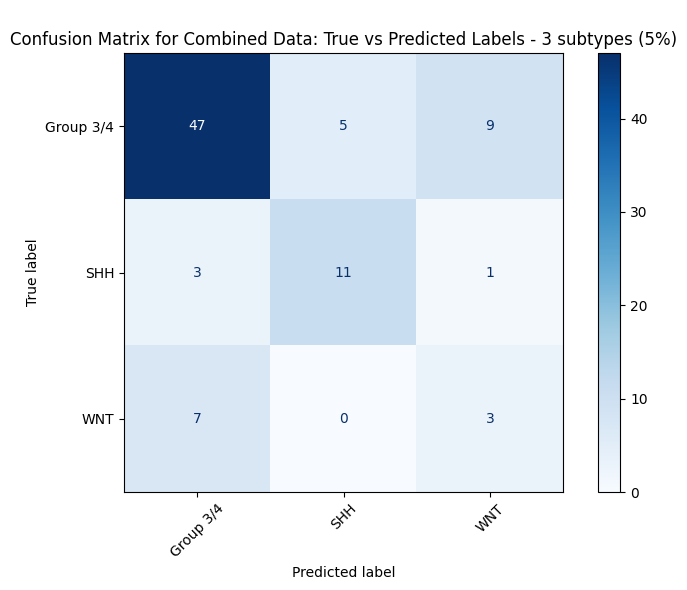

In [61]:
#Combined - 5%

print("\033[1mCombined - 3 subtype (5%)\033[0m")

#Accuracy score
avg_accuracy_3 = accuracy_score(results_df_rp_3['True Label'], results_df_rp_3['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_3)

#F1 score
avg_f1_3 = f1_score(results_df_rp_3['True Label'], results_df_rp_3['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_3)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_rp_3['True Label'])
y_pred_bin = lb.transform(results_df_rp_3['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_3 = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_3 = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_3)

#Plot
cm_3 = confusion_matrix(results_df_rp_3['True Label'], results_df_rp_3['Predicted Label'])

labels = sorted(results_df_rp_3['True Label'].unique())  # or use a manual list if the order matters
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_3.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Combined Data: True vs Predicted Labels - 3 subtypes (5%)")
plt.tight_layout()
plt.show()

In [ ]:
#Combined - 10%
subjs_list_rp_3 = df_rp_3['CBTN Subject ID'].unique()
results_rp_10 = []

print("\033[1mCombined - 3 subtypes (10%)\033[0m")

for sub_ids in subjs_list_rp_3:
    test_mask_rp_10 = df_rp_3['CBTN Subject ID'] == sub_ids
    train_mask_rp_10 = ~test_mask_rp_10

    X_train_rp_10 = X_rp_3[train_mask_rp_10].values
    y_train_rp_10 = y_rp_3[train_mask_rp_10].values
    X_test_rp_10 = X_rp_3[test_mask_rp_10].values
    y_test_rp_10 = y_rp_3[test_mask_rp_10].values

    # Feature selection using training data only
    selector_10 = SelectPercentile(score_func=f_classif, percentile=10)
    X_train_sel_10 = selector_10.fit_transform(X_train_rp_10, y_train_rp_10)
    X_test_sel_10 = selector_10.transform(X_test_rp_10)

    # Fit and predict
    clf_rp_3.fit(X_train_sel_10, y_train_rp_10)
    y_pred_rp_10 = clf_rp_3.predict(X_test_sel_10)

    # Store results
    for true, pred in zip(y_test_rp_10, y_pred_rp_10):
        results_rp_10.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_rp_10 = pd.DataFrame(results_rp_10)
print(results_df_rp_10)

Combined - 3 subtypes (10%)

Average Accuracy: 0.6395348837209303
Weighted F1 Score: 0.6635616464617832
AUC Score: 0.6840511489992586


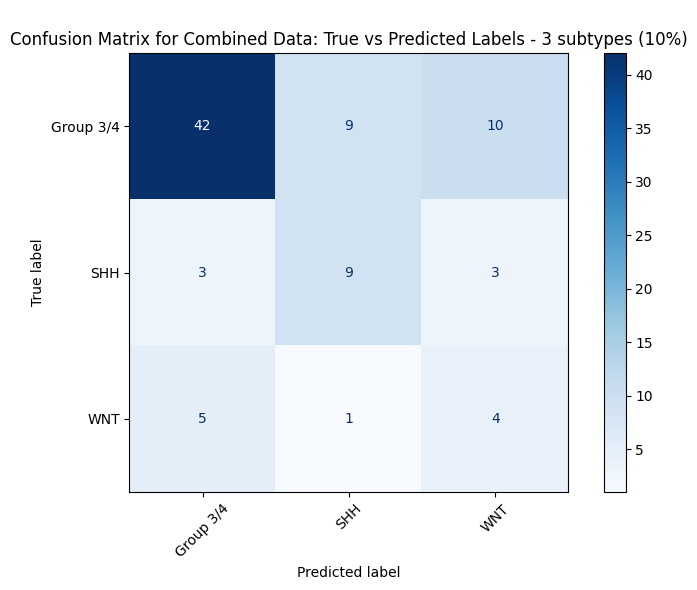

In [77]:
#Combined - 10%

print("\033[1mCombined - 3 subtypes (10%)\033[0m")

#Accuracy score
avg_accuracy_10 = accuracy_score(results_df_rp_10['True Label'], results_df_rp_10['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_10)

#F1 score
avg_f1_10 = f1_score(results_df_rp_10['True Label'], results_df_rp_10['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_10)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_rp_10['True Label'])
y_pred_bin = lb.transform(results_df_rp_10['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_10 = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_10 = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_10)

#Plot
cm_10 = confusion_matrix(results_df_rp_10['True Label'], results_df_rp_10['Predicted Label'])

labels = sorted(results_df_rp_10['True Label'].unique())
disp_10 = ConfusionMatrixDisplay(confusion_matrix=cm_10, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_10.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Combined Data: True vs Predicted Labels - 3 subtypes (10%)")
plt.tight_layout()
plt.show()

##2 Subtype Analysis (SHH/WNT vs Group 3/4)

In [46]:
#RADIOMIC

subtype_grouping = {
    'MB, SHH': 'SHH/WNT',
    'MB, WNT': 'SHH/WNT',
    'MB, Group3': 'Group 3/4',
    'MB, Group4': 'Group 3/4'}

#Merge labels with radiomic features
df_rad_2 = df_radiomic.merge(df_molec_radiomic[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape radiomic', df_rad.shape)

X_rad_2 = df_rad_2.drop(columns=['CBTN Subject ID', 'OpenPedCan Molecular Subtype'])
y_rad_2 = df_rad['OpenPedCan Molecular Subtype'].map(subtype_grouping)

clf_rad_2 = LinearSVC(random_state=42, max_iter=10000)

print('\n', y_rad_2.value_counts())

Shape radiomic (96, 558)

 OpenPedCan Molecular Subtype
Group 3/4    65
SHH/WNT      31
Name: count, dtype: int64


In [ ]:
#RADIOMIC - 5%
subjs_list_rad_2 = df_rad_2['CBTN Subject ID'].unique()
results_rad_2 = []

print("\033[1mRadiomic - 2 subtypes\033[0m")

for sub_ids in subjs_list_rad_2:
    test_mask_rad_2 = df_rad_2['CBTN Subject ID'] == sub_ids
    train_mask_rad_2 = ~test_mask_rad_2

    X_train_rad_2 = X_rad_2[train_mask_rad_2].values
    y_train_rad_2 = y_rad_2[train_mask_rad_2].values
    X_test_rad_2 = X_rad_2[test_mask_rad_2].values
    y_test_rad_2 = y_rad_2[test_mask_rad_2].values

    # Feature selection using training data only
    selector_2 = SelectPercentile(score_func=f_classif, percentile=5)
    X_train_sel_2 = selector.fit_transform(X_train_rad_2, y_train_rad_2)
    X_test_sel_2 = selector.transform(X_test_rad_2)

    # Fit and predict
    clf_rad_2.fit(X_train_sel_2, y_train_rad_2)
    y_pred_rad_2 = clf_rad_2.predict(X_test_sel_2)

    # Store results
    for true, pred in zip(y_test_rad_2, y_pred_rad_2):
        results_rad_2.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_rad_2 = pd.DataFrame(results_rad_2)
print(results_df_rad_2)

Radiomic - 2 subtype

Average Accuracy: 0.7083333333333334
Weighted F1 Score: 0.7026290958998113
AUC Score: 0.6496277915632754


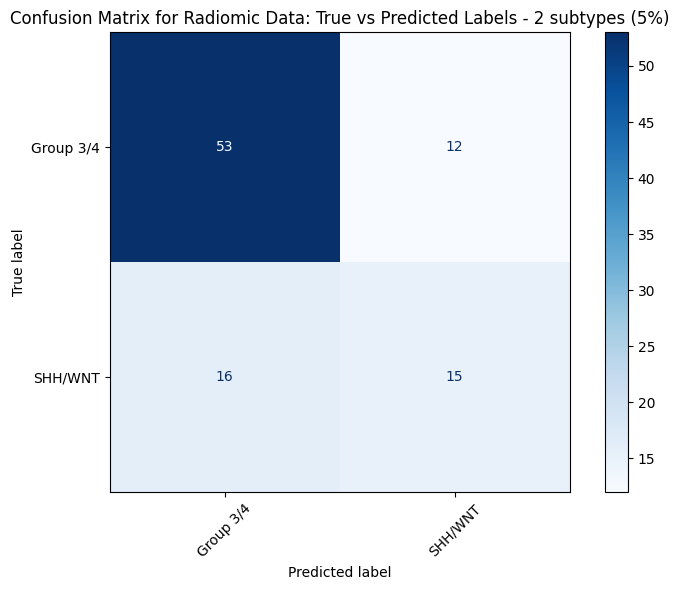

In [79]:
#RADIOMIC - 5%

print("\033[1mRadiomic - 2 subtype\033[0m")

#Accuracy score
avg_accuracy_2 = accuracy_score(results_df_rad_2['True Label'], results_df_rad_2['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_2)

#F1 score
avg_f1_2 = f1_score(results_df_rad_2['True Label'], results_df_rad_2['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_2)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_rad_2['True Label'])
y_pred_bin = lb.transform(results_df_rad_2['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_2 = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_2 = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_2)

#Plot
cm_2 = confusion_matrix(results_df_rad_2['True Label'], results_df_rad_2['Predicted Label'])

labels = sorted(results_df_rad_2['True Label'].unique())
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_2.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Radiomic Data: True vs Predicted Labels - 2 subtypes (5%)")
plt.tight_layout()
plt.show()

In [49]:
#PATHOMIC

subtype_grouping = {
    'MB, SHH': 'SHH/WNT',
    'MB, WNT': 'SHH/WNT',
    'MB, Group3': 'Group 3/4',
    'MB, Group4': 'Group 3/4'
}

#Merge labels with pathomic features
df_path_2 = df_pathomic.merge(df_molec_pathomic[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape pathomic', df_path_2.shape)

X_path_2 = df_path_2.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'OpenPedCan Molecular Subtype'])
y_path_2 = df_path['OpenPedCan Molecular Subtype'].map(subtype_grouping)

clf_path_2 = LinearSVC(random_state=42, max_iter=10000)

print('\n', y_path_2.value_counts())

Shape pathomic (173, 133)

 OpenPedCan Molecular Subtype
Group 3/4    116
SHH/WNT       57
Name: count, dtype: int64


In [ ]:
#PATHOMIC - all
subjs_list_path_2 = df_path_2['CBTN Subject ID'].unique()
results_path_2 = []

print("\033[1mPathomic - 2 subtypes\033[0m")

for sub_ids in subjs_list_path_2:
    test_mask_path_2 = df_path_2['CBTN Subject ID'] == sub_ids
    train_mask_path_2 = ~test_mask_path_2

    X_train_path_2 = X_path_2[train_mask_path_2].values
    y_train_path_2 = y_path_2[train_mask_path_2].values
    X_test_path_2 = X_path_2[test_mask_path_2].values
    y_test_path_2 = y_path_2[test_mask_path_2].values

    # Fit and predict
    clf_path_2.fit(X_train_path_2, y_train_path_2)
    y_pred_path_2 = clf_path_2.predict(X_test_path_2)

    # Store results
    for true, pred in zip(y_test_path_2, y_pred_path_2):
        results_path_2.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_path_2 = pd.DataFrame(results_path_2)
print(results_df_path_2)

#PATHOMIC
subjs_list_path = df_path['CBTN Subject ID'].unique()
results_path = []

Pathomic - 2 subtype

Average Accuracy: 0.6705202312138728
Weighted F1 Score: 0.6681708642599061
AUC Score: 0.6204627949183303


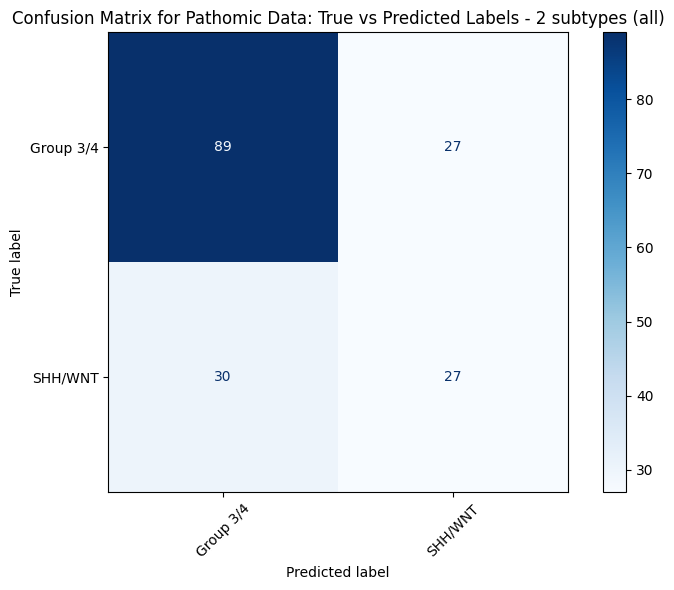

In [80]:
#PATHOMIC - all

print("\033[1mPathomic - 2 subtype\033[0m")

#Accuracy score
avg_accuracy_2 = accuracy_score(results_df_path_2['True Label'], results_df_path_2['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_2)

#F1 score
avg_f1_2 = f1_score(results_df_path_2['True Label'], results_df_path_2['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_2)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_path_2['True Label'])
y_pred_bin = lb.transform(results_df_path_2['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_2 = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_2 = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_2)

#Plot
cm_2 = confusion_matrix(results_df_path_2['True Label'], results_df_path_2['Predicted Label'])

labels = sorted(results_df_path_2['True Label'].unique())
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_2.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Pathomic Data: True vs Predicted Labels - 2 subtypes (all)")
plt.tight_layout()
plt.show()

In [ ]:
#PATHOMIC - 5%
subjs_list_path_2_5 = df_path_2['CBTN Subject ID'].unique()
results_path_2_5 = []

print("\033[1mPathomic - 2 subtypes (5%)\033[0m")

for sub_ids in subjs_list_path_2_5:
    test_mask_path_2_5 = df_path_2['CBTN Subject ID'] == sub_ids
    train_mask_path_2_5 = ~test_mask_path_2_5

    X_train_path_2_5 = X_path_2[train_mask_path_2_5].values
    y_train_path_2_5 = y_path_2[train_mask_path_2_5].values
    X_test_path_2_5 = X_path_2[test_mask_path_2_5].values
    y_test_path_2_5 = y_path_2[test_mask_path_2_5].values

# Feature selection using training data only
    selector_path_2_5 = SelectPercentile(score_func=f_classif, percentile=5)
    X_train_sel_path_2_5 = selector_path_2_5.fit_transform(X_train_path_2_5, y_train_path_2_5)
    X_test_sel_path_2_5 = selector_path_2_5.transform(X_test_path_2_5)

    # Fit and predict
    clf_path_2.fit(X_train_sel_path_2_5, y_train_path_2_5)
    y_pred_path_2_5 = clf_path_2.predict(X_test_sel_path_2_5)

    # Store results
    for true, pred in zip(y_test_path_2_5, y_pred_path_2_5):
        results_path_2_5.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_path_2_5 = pd.DataFrame(results_path_2_5)
print(results_df_path_2_5)

Pathomic - 2 subtypes (5%)

Average Accuracy: 0.653179190751445
Weighted F1 Score: 0.5964375543359238
AUC Score: 0.5272232304900182


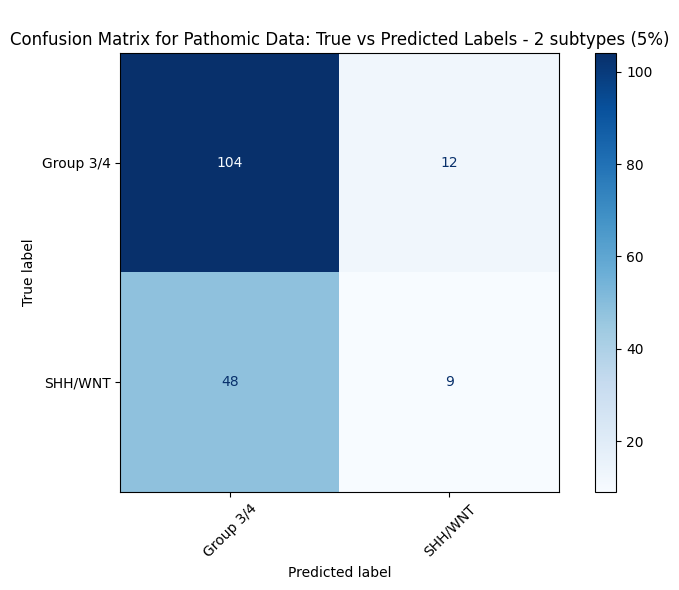

In [81]:
#PATHOMIC - 5%

print("\033[1mPathomic - 2 subtypes (5%)\033[0m")

#Accuracy score
avg_accuracy_2_5 = accuracy_score(results_df_path_2_5['True Label'], results_df_path_2_5['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_2_5)

#F1 score
avg_f1_2_5 = f1_score(results_df_path_2_5['True Label'], results_df_path_2_5['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_2_5)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_path_2_5['True Label'])
y_pred_bin = lb.transform(results_df_path_2_5['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_2_5 = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_2_5 = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_2_5)

#Plot
cm_2_5 = confusion_matrix(results_df_path_2_5['True Label'], results_df_path_2_5['Predicted Label'])

labels = sorted(results_df_path_2_5['True Label'].unique())
disp_2_5 = ConfusionMatrixDisplay(confusion_matrix=cm_2_5, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_2_5.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Pathomic Data: True vs Predicted Labels - 2 subtypes (5%)")
plt.tight_layout()
plt.show()

In [54]:
#Combined
#File names: df_rad_path & df_molec_combined
  #File names pt 2: df_rp

subtype_grouping = {
    'MB, SHH': 'SHH/WNT',
    'MB, WNT': 'SHH/WNT',
    'MB, Group3': 'Group 3/4',
    'MB, Group4': 'Group 3/4'}

#Merge labels with radiomic features
df_rp_2 = df_rad_path.merge(df_molec_combined[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']], on='CBTN Subject ID')

print('Shape combined', df_rp_2.shape)

X_rp_2 = df_rp_2.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'OpenPedCan Molecular Subtype'])
y_rp_2 = df_rp_2['OpenPedCan Molecular Subtype'].map(subtype_grouping)

clf_rp_2 = LinearSVC(random_state=42, max_iter=10000)

print('\n', y_rp_2.value_counts())

Shape combined (86, 688)

 OpenPedCan Molecular Subtype
Group 3/4    61
SHH/WNT      25
Name: count, dtype: int64


In [ ]:
#Combined - 5%
subjs_list_rp_2 = df_rp_2['CBTN Subject ID'].unique()
results_rp_2 = []

print("\033[1mCombined - 2 subtypes\033[0m")

for sub_ids in subjs_list_rp_2:
    test_mask_rp_2 = df_rp_2['CBTN Subject ID'] == sub_ids
    train_mask_rp_2 = ~test_mask_rp_2

    X_train_rp_2 = X_rp_2[train_mask_rp_2].values
    y_train_rp_2 = y_rp_2[train_mask_rp_2].values
    X_test_rp_2 = X_rp_2[test_mask_rp_2].values
    y_test_rp_2 = y_rp_2[test_mask_rp_2].values

    # Feature selection using training data only
    selector_rp_2 = SelectPercentile(score_func=f_classif, percentile=5)
    X_train_sel_2 = selector_rp_2.fit_transform(X_train_rp_2, y_train_rp_2)
    X_test_sel_2 = selector_rp_2.transform(X_test_rp_2)

    # Fit and predict
    clf_rp_2.fit(X_train_sel_2, y_train_rp_2)
    y_pred_rp_2 = clf_rp_2.predict(X_test_sel_2)

    # Store results
    for true, pred in zip(y_test_rp_2, y_pred_rp_2):
        results_rp_2.append({'Subject ID': sub_ids, 'True Label': true, 'Predicted Label': pred})

results_df_rp_2 = pd.DataFrame(results_rp_2)
print(results_df_rp_2)

Combined - 2 subtype (5%)

Average Accuracy: 0.686046511627907
Weighted F1 Score: 0.6841191382962714
AUC Score: 0.6134426229508196


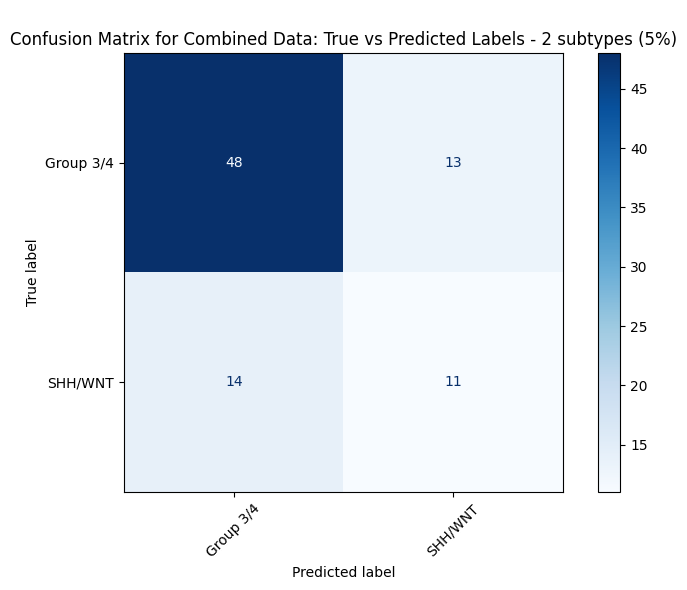

In [82]:
#Combined - 5%

print("\033[1mCombined - 2 subtype (5%)\033[0m")

#Accuracy score
avg_accuracy_2 = accuracy_score(results_df_rp_2['True Label'], results_df_rp_2['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy_2)

#F1 score
avg_f1_2 = f1_score(results_df_rp_2['True Label'], results_df_rp_2['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1_2)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_rp_2['True Label'])
y_pred_bin = lb.transform(results_df_rp_2['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_2 = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_2 = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_2)

#Plot
cm_2 = confusion_matrix(results_df_rp_2['True Label'], results_df_rp_2['Predicted Label'])

labels = sorted(results_df_rp_2['True Label'].unique())
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_2.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Combined Data: True vs Predicted Labels - 2 subtypes (5%)")
plt.tight_layout()
plt.show()

##SMOTE

###Radiomic

Counter({'MB, Group4': 41, 'MB, Group3': 24, 'MB, SHH': 20, 'MB, WNT': 11})


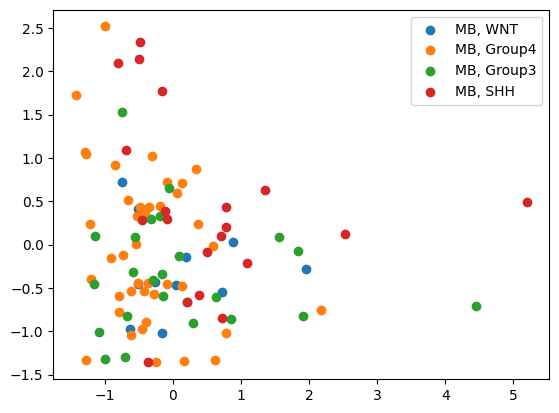

Index(['T1_tumor_core_Intensity_CoefficientOfVariation', 'T1_tumor_core_Intensity_Energy'], dtype='object')

SMOTE Data Set
Counter({'MB, WNT': 41, 'MB, Group4': 41, 'MB, Group3': 41, 'MB, SHH': 41})


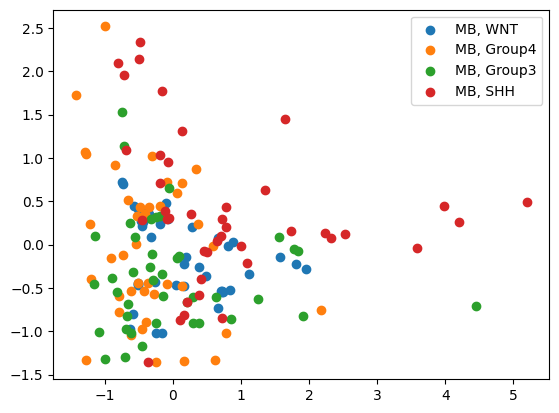

In [57]:
X_rad = df_rad.drop(columns=['CBTN Subject ID', 'OpenPedCan Molecular Subtype'])
y_rad = df_rad['OpenPedCan Molecular Subtype']

# summarize class distribution
counter = Counter(y_rad)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y_rad == label)[0]
	plt.scatter(X_rad.iloc[row_ix, 0], X_rad.iloc[row_ix, 1], label=str(label))
plt.legend()
plt.show()

print(X_rad.columns[:2])

print("\n\033[1mSMOTE Data Set\033[0m")

# transform the dataset
oversample = SMOTE(random_state=42)
X_resamp_rad, y_resamp_rad = oversample.fit_resample(X_rad, y_rad)

counter = Counter(y_resamp_rad)
print(counter)

for label, _ in counter.items():
	row_ix = where(y_resamp_rad == label)[0]
	plt.scatter(X_resamp_rad.iloc[row_ix, 0], X_resamp_rad.iloc[row_ix, 1], label=str(label))
plt.legend()
plt.show()


Average Accuracy: 0.7575757575757576
Weighted F1 Score: 0.7633194692018221
AUC Score: 0.8391666666666667


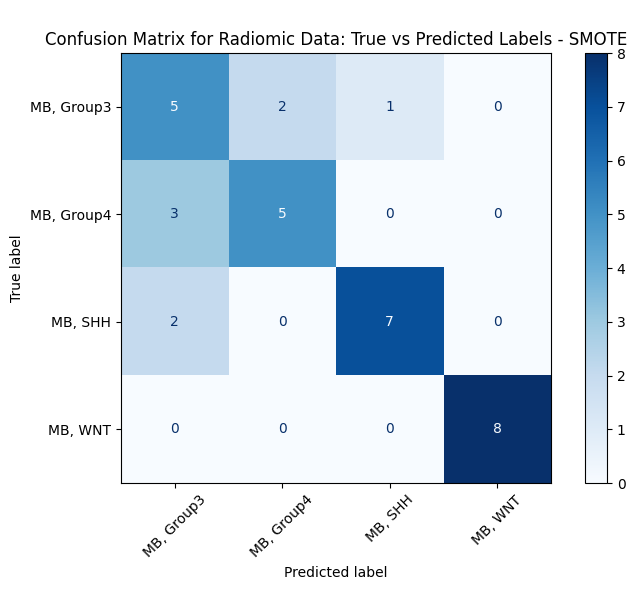

In [83]:
##4 subtypes

selector_rad = SelectPercentile(score_func=f_classif, percentile=5)
X_sel_rad = selector_rad.fit_transform(X_resamp_rad, y_resamp_rad)

X_train_rad, X_test_rad, y_train_rad, y_test_rad = train_test_split(
    X_sel_rad, y_resamp_rad, test_size=0.2, stratify=y_resamp_rad, random_state=42)

# Train and evaluate SVM
clf_rad = LinearSVC(random_state=42, max_iter=10000)
clf_rad.fit(X_train_rad, y_train_rad)
y_pred_rad = clf_rad.predict(X_test_rad)

results_df_rad_reduced = pd.DataFrame({
    'True Label': y_test_rad,
    'Predicted Label': y_pred_rad})

#Accuracy score
avg_accuracy = accuracy_score(results_df_rad_reduced['True Label'], results_df_rad_reduced['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy)

#F1 score
avg_f1 = f1_score(results_df_rad_reduced['True Label'], results_df_rad_reduced['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_rad_reduced['True Label'])
y_pred_bin = lb.transform(results_df_rad_reduced['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_rad_reduc = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_rad_reduc = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_rad_reduc)

#Plot
cm_rad_reduc = confusion_matrix(results_df_rad_reduced['True Label'], results_df_rad_reduced['Predicted Label'])

labels = sorted(results_df_rad_reduced['True Label'].unique())
disp_rad_reduc = ConfusionMatrixDisplay(confusion_matrix=cm_rad_reduc, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_rad_reduc.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Radiomic Data: True vs Predicted Labels - SMOTE")
plt.tight_layout()
plt.show()

###Pathomic

Counter({'MB, Group4': 70, 'MB, Group3': 46, 'MB, SHH': 39, 'MB, WNT': 18})


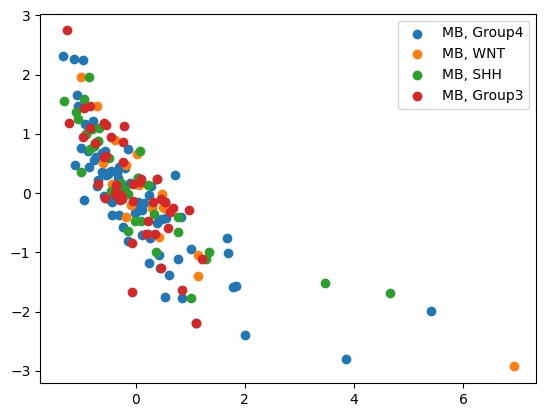

Index(['Size.Area', 'Shape.Circularity'], dtype='object')

SMOTE Data Set
Counter({'MB, Group4': 70, 'MB, WNT': 70, 'MB, SHH': 70, 'MB, Group3': 70})


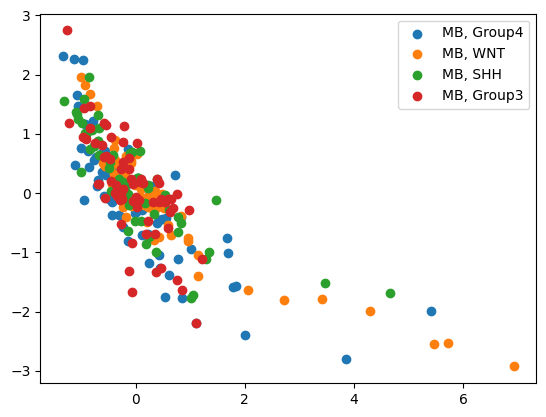

In [59]:
X_path = df_path.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'OpenPedCan Molecular Subtype'])
y_path = df_path['OpenPedCan Molecular Subtype']

# summarize class distribution
counter = Counter(y_path)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y_path == label)[0]
	plt.scatter(X_path.iloc[row_ix, 0], X_path.iloc[row_ix, 1], label=str(label))
plt.legend()
plt.show()

print(X_path.columns[:2])

print("\n\033[1mSMOTE Data Set\033[0m")

# transform the dataset
oversample = SMOTE(random_state=42)
X_resamp_path, y_resamp_path = oversample.fit_resample(X_path, y_path)

counter = Counter(y_resamp_path)
print(counter)

for label, _ in counter.items():
	row_ix = where(y_resamp_path == label)[0]
	plt.scatter(X_resamp_path.iloc[row_ix, 0], X_resamp_path.iloc[row_ix, 1], label=str(label))
plt.legend()
plt.show()


Average Accuracy: 0.75
Weighted F1 Score: 0.7065118092691621
AUC Score: 0.8333333333333333


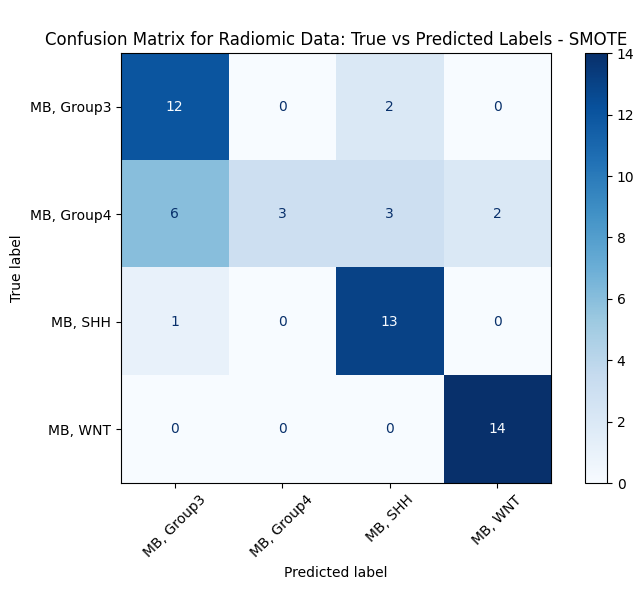

In [84]:
## 4 subtypes
X_train_path, X_test_path, y_train_path, y_test_path = train_test_split(
    X_resamp_path, y_resamp_path, test_size=0.2, stratify=y_resamp_path, random_state=42)

# Train and evaluate SVM
clf_path = LinearSVC(random_state=42, max_iter=10000)
clf_path.fit(X_train_path, y_train_path)
y_pred_path = clf_path.predict(X_test_path)

# Store results
results_df_path_reduced = pd.DataFrame({
    'True Label': y_test_path,
    'Predicted Label': y_pred_path})

#Accuracy score
avg_accuracy = accuracy_score(results_df_path_reduced['True Label'], results_df_path_reduced['Predicted Label'])
print("\nAverage Accuracy:", avg_accuracy)

#F1 score
avg_f1 = f1_score(results_df_path_reduced['True Label'], results_df_path_reduced['Predicted Label'], average='weighted')
print("Weighted F1 Score:", avg_f1)

#AUC score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(results_df_path_reduced['True Label'])
y_pred_bin = lb.transform(results_df_path_reduced['Predicted Label'])

if y_true_bin.shape[1] == 1:
    auc_score_path_reduc = roc_auc_score(y_true_bin, y_pred_bin)
else:
    auc_score_path_reduc = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

print("AUC Score:", auc_score_path_reduc)

#Plot
cm_path_reduc = confusion_matrix(results_df_path_reduced['True Label'], results_df_path_reduced['Predicted Label'])

labels = sorted(results_df_path_reduced['True Label'].unique())
disp_path_reduc = ConfusionMatrixDisplay(confusion_matrix=cm_path_reduc, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp_path_reduc.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("\nConfusion Matrix for Radiomic Data: True vs Predicted Labels - SMOTE")
plt.tight_layout()
plt.show()